In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [68]:
# Load Data
train_data = pd.read_csv('278_labelled_uri_train.csv')

In [69]:
# Visualize Data
# train_data.describe()
# train_data.info()
# print(train_data.keys())


labels = pd.DataFrame(train_data['labels'])
train_data.drop('labels', axis=1, inplace=True)
train_data.drop('uri', axis=1, inplace=True)

# train_data['id'] = range(len(train_data))
# labels['id'] = range(len(labels))

In [70]:
train_data.describe()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222350 entries, 0 to 222349
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0.2      222350 non-null  int64  
 1   Unnamed: 0.1      222350 non-null  int64  
 2   Unnamed: 0        222350 non-null  int64  
 3   duration (ms)     222350 non-null  float64
 4   danceability      222350 non-null  float64
 5   energy            222350 non-null  float64
 6   loudness          222350 non-null  float64
 7   speechiness       222350 non-null  float64
 8   acousticness      222350 non-null  float64
 9   instrumentalness  222350 non-null  float64
 10  liveness          222350 non-null  float64
 11  valence           222350 non-null  float64
 12  tempo             222350 non-null  float64
 13  spec_rate         222350 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 23.7 MB


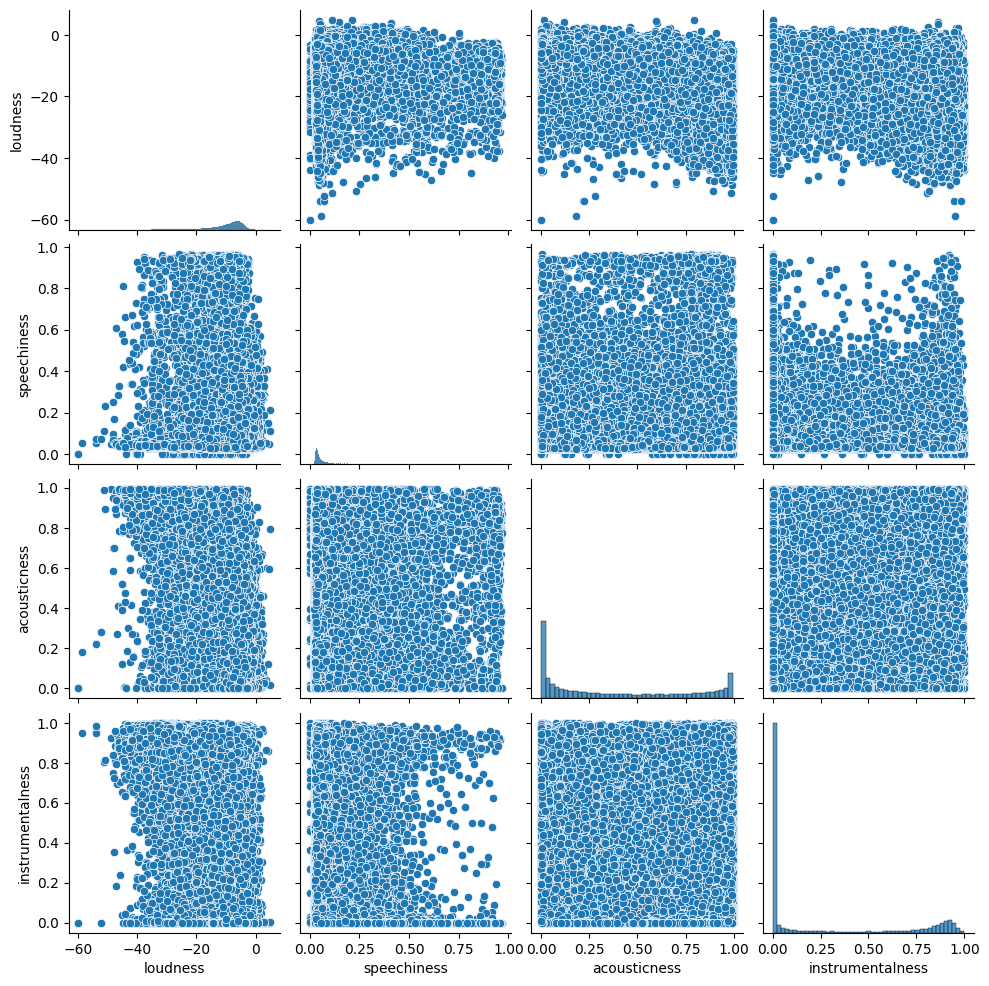

In [71]:
sns.pairplot(train_data[['loudness', 'speechiness', 'acousticness', 'instrumentalness']])


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fc64e206a20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

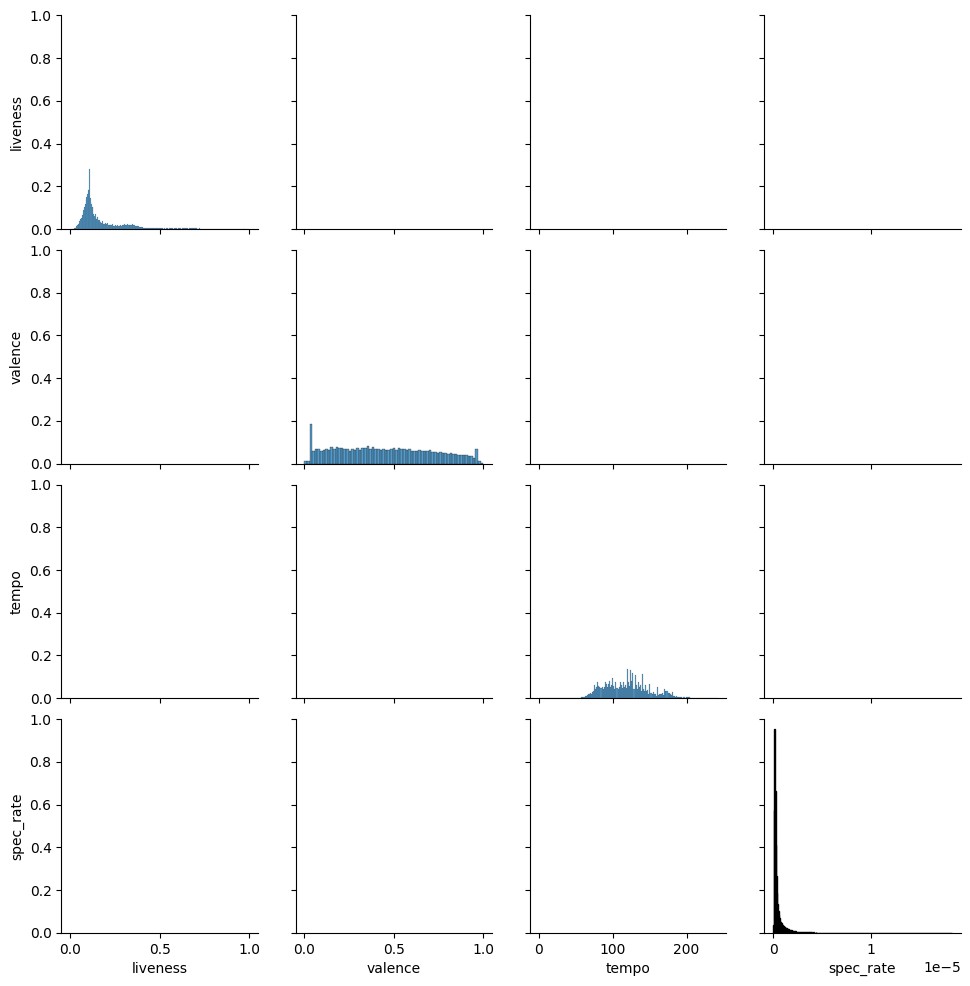

In [71]:
sns.pairplot(train_data[['liveness', 'valence', 'tempo', 'spec_rate']])

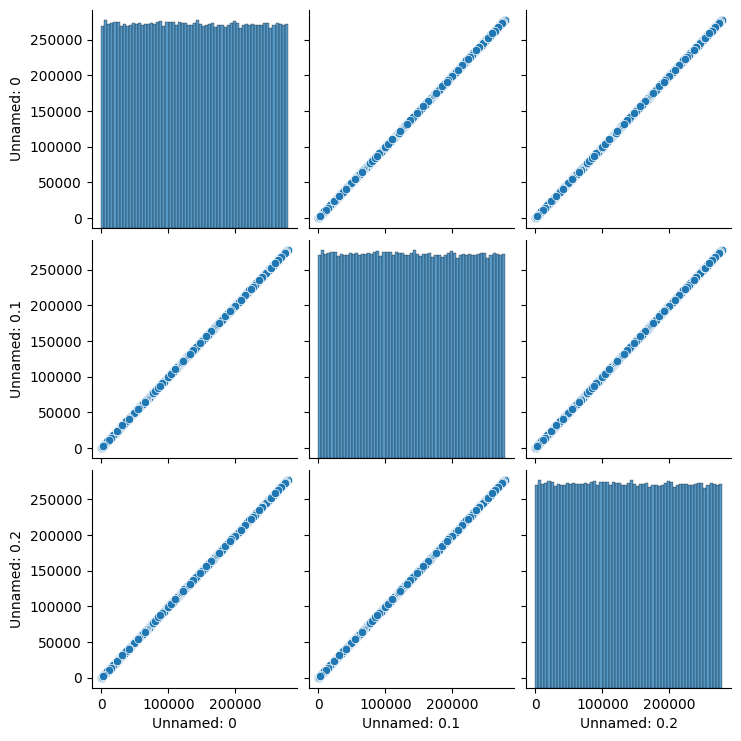

In [59]:
sns.pairplot(train_data[['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2']])

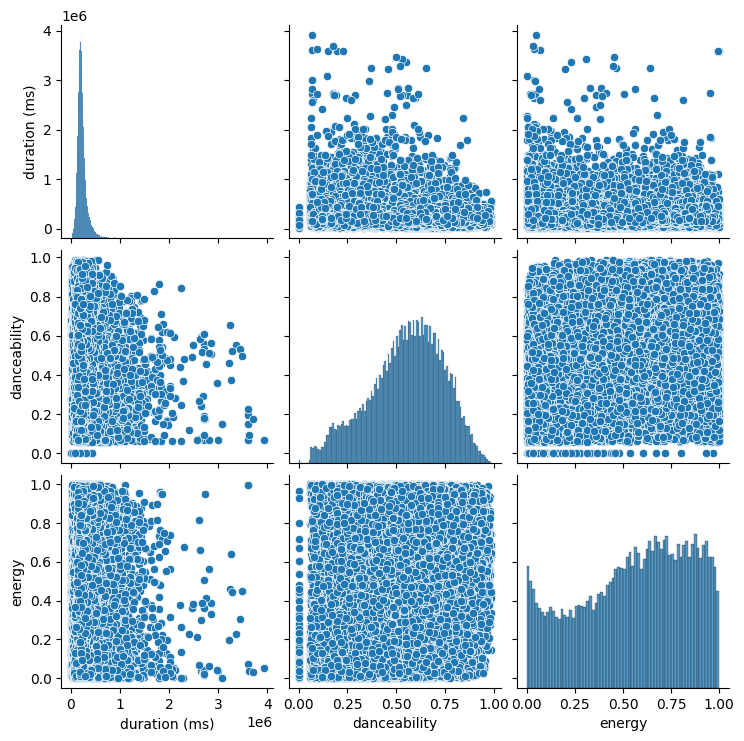

In [60]:
sns.pairplot(train_data[['duration (ms)', 'danceability', 'energy']])

In [61]:
# Remove Unnamed colums
train_data.drop('Unnamed: 0', axis=1, inplace=True)
train_data.drop('Unnamed: 0.1', axis=1, inplace=True)
train_data.drop('Unnamed: 0.2', axis=1, inplace=True)

In [62]:
# Create test-train splitt
X_train, X_test, y_train, y_test = train_test_split(train_data[['energy', 'liveness', 'valence', 'loudness']], labels, test_size=0.2)

In [63]:
# Train a XGBoost algorithm
xgb_classifier = XGBClassifier()
xgb_params = {'booster': ['gblinear', 'gbtree', 'dart'], 'max_depth': [2, 6, 12], 'n_estimators': [15, 10]}

pipeline = Pipeline([
    ('normalizer', Normalizer()),
    # ('classifier', GridSearchCV(logistic_regression, logistic_regression_params)),
    # ('classifier', LogisticRegressionCV(cv=cross_validator, verbose=1, max_iter=200))
    #('classifier', GridSearchCV(estimator=decision_tree, param_grid=decision_tree_params)),
    ('classifier', XGBClassifier(n_estimators=9, max_depth=10, objective='binary:logistic', verbosity=1))
    #('classifier', GridSearchCV(estimator=xgb_classifier, param_grid=xgb_params)),
])
pipeline.fit(X_train, y_train)


,steps,"[('normalizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,norm,'l2'
,copy,True
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


Matches: labels    30393
dtype: int64 of 44470
Accuracy: labels    0.68345
dtype: float64


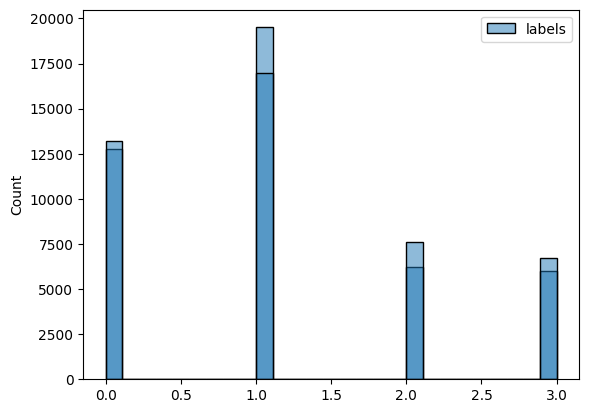

In [75]:
# # Test the performance of the model in the test/train split
y_pred = pipeline.predict(X_test)

y_pred = pd.Series(y_pred, index=y_test.index)
y_test_s = pd.Series(y_test['labels'], index=y_test.index)

sns.histplot(y_pred_df)
sns.histplot(y_test)

matches = (y_test == y_pred_df)
print(f'Matches: {matches.sum()} of {len(y_test)}')
print(f'Accuracy: {matches.sum() / len(y_pred_df)}')